# Ladies First Bird Classification Project
### Authors: Joice, Alda and Yelin
---

You will use the [Bird Species dataset](https://www.kaggle.com/gpiosenka/100-bird-species) from Kaggle.

### The dataset contains:
- 525 bird species
- 84635 training images, 2625 test images(5 images per species)
- 2625 validation images (5 images per species)

Your goal is to build an image classification model with the best possible performance. You will work in a group, and at the end, as a group you will present your work to your instructor and classmates.

### Requirements:
- Choose 15 species that you want to train/classify
- Compile a classification model (you can choose any image classification model you want). Your accuracy should be at least 85%
- Make sure that your training, testing AND validation sets contain the same classes of species
- Save your final model, and use the validation set to evaluate its performance during the group presentation

### Tips:
- Use Google Colab for larger/more complex models
- Consider using data augmentation to improve your model's performance
- Make sure to read the datasets [Data Card](https://www.kaggle.com/datasets/gpiosenka/100-bird-species) to get a better understanding of the images and the structure/dimensions of the files

### Good Luck!

## Imports and Data Loading 

In [4]:
# Basic Imports
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Image
from PIL import Image
from pathlib import Path
from matplotlib.image import imread
import glob

# tensorflow
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Evaluation
from sklearn.metrics import classification_report


In [5]:
# Define path to data directory
train_data_dir = '../birds_selection/train_data'
test_data_dir = '../birds_selection/test_data'
valid_data_dir = '../birds_selection/valid_data'

## EDA
Major findings from the data source page:
1. Each species should have 130+ training images, and 5 images each for test and validation. The class is not perfectly balanced. 
2. All the images were cropped into 224*224 such that the bird occupies more than 50% of the pixels. 
3. There are around 80% males and 20% females in the species with evident sex dimorphism. 
4. Test and validation images were hand picked to be the "best-quality" images for the model to classify. 

In [7]:
# Display the number of images in each folder
train_data = image_dataset_from_directory(train_data_dir,
                                          image_size=(224, 224),
                                          batch_size=16)

test_data = image_dataset_from_directory(test_data_dir,
                                         image_size=(224, 224),
                                         batch_size=16)

valid_data = image_dataset_from_directory(valid_data_dir,
                                          image_size=(224, 224),
                                          batch_size=16)

Found 2389 files belonging to 15 classes.
Found 75 files belonging to 15 classes.
Found 75 files belonging to 15 classes.


In [8]:
# Display the 15 species class in training dataset
class_names = train_data.class_names
class_names

['AMERICAN AVOCET',
 'AMERICAN FLAMINGO',
 'BALD EAGLE',
 'BANDED BROADBILL',
 'BARN OWL',
 'BLONDE CRESTED WOODPECKER',
 'CROW',
 'IWI',
 'LILAC ROLLER',
 'PEACOCK',
 'PUFFIN',
 'ROSY FACED LOVEBIRD',
 'RUDY KINGFISHER',
 'TRUMPTER SWAN',
 'WHITE EARED HUMMINGBIRD']

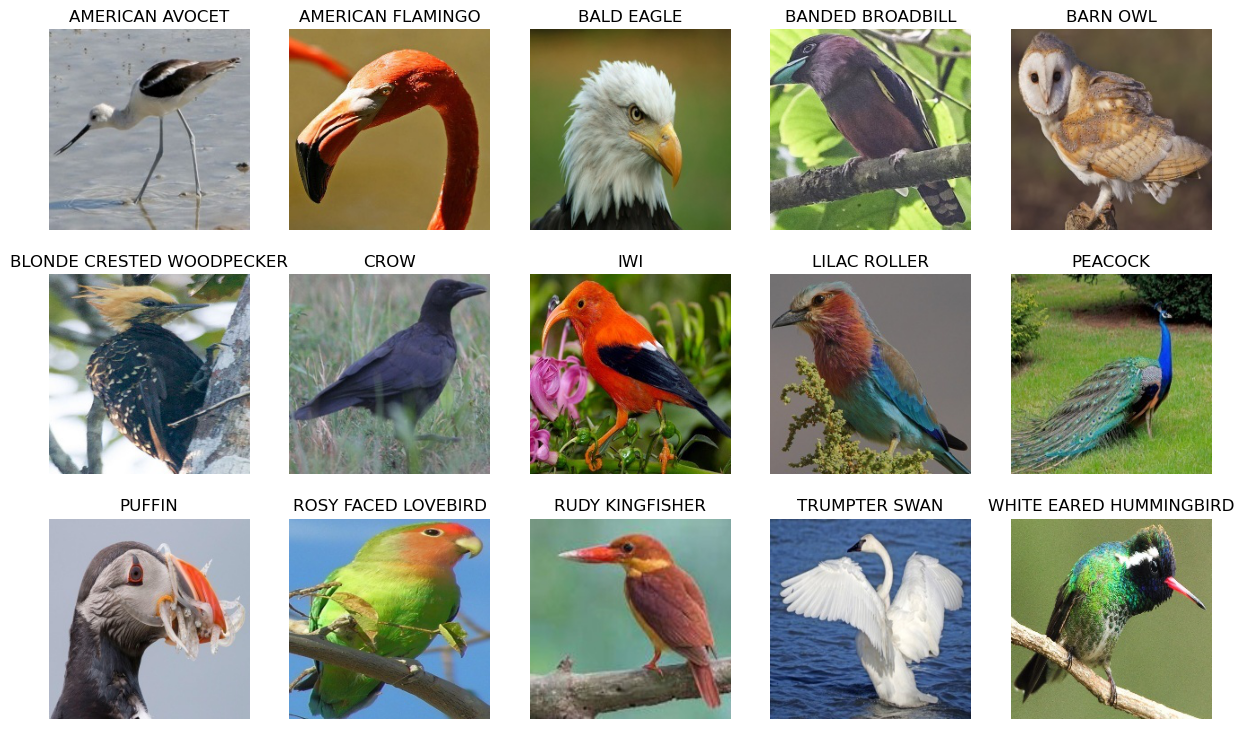

In [9]:
# Display one image from each folder
plt.figure(figsize=(15, 9))

for i, label in enumerate(os.listdir(train_data_dir)):
    species_dir = os.path.join(train_data_dir, label)

    # Get the first image in the species directory
    image_dir = os.path.join(species_dir, os.listdir(species_dir)[0])

    # Open the image
    img = Image.open(image_dir)

    plt.subplot(3, 5, i + 1)  
    plt.imshow(img)
    plt.title(label)
    plt.axis('off') 

## Preprocessing using ImageDataGenerator

As stated in the data source, all the image are cropped to the size of 224\*224\*3. Therefor, 224*224 is chosen as the targe size. 

In [11]:
# Create an ImageDataGenerator for training augmentation and preprocessing 
img_gen = ImageDataGenerator(rescale=1./255,
                             rotation_range=20,       
                             width_shift_range=0.2,   
                             height_shift_range=0.2,  
                             shear_range=0.2,         
                             zoom_range=0.2,          
                             horizontal_flip=True,   
                             fill_mode='nearest')

train_data_aug = img_gen.flow_from_directory(train_data_dir,
                                             target_size=(224, 224), # same as original image dimensions
                                             batch_size=16,
                                             shuffle=True)

Found 2389 images belonging to 15 classes.


In [56]:
# Create an ImageDataGenerator for validation dataset and test dataset
img_gen_valid = ImageDataGenerator(rescale=1./255)

valid_dataset = img_gen_valid.flow_from_directory(valid_data_dir,
                                                  target_size=(224,224), # same as original image dimensions
                                                  batch_size=1,
                                                  shuffle=False)

test_dataset = img_gen_valid.flow_from_directory(test_data_dir,
                                                 target_size=(224,224),
                                                 batch_size=1,
                                                 shuffle=False)

Found 75 images belonging to 15 classes.
Found 75 images belonging to 15 classes.


## Model Establishment

In [39]:
cnn = Sequential()

# Input Layer
cnn.add(Conv2D(filters=32,
               kernel_size=3,
               padding='valid',
               input_shape=(224, 224, 3), 
               activation='relu'))

        
# First Conv2D layer
cnn.add(Conv2D(filters=32, 
               kernel_size=3, 
               activation='relu'))
cnn.add(MaxPool2D(pool_size=(2, 2)))


# Second Conv2D layer
cnn.add(Conv2D(filters=64, 
               kernel_size=3, 
               activation='relu'))
cnn.add(MaxPool2D(pool_size=(2, 2)))


# Third Conv2D layer
cnn.add(Conv2D(filters=128, 
               kernel_size=3, 
               activation='relu'))
cnn.add(MaxPool2D(pool_size=(2, 2)))


# Fourth Conv2D layer
cnn.add(Conv2D(filters=256, 
               kernel_size=3, 
               activation='relu'))
cnn.add(MaxPool2D(pool_size=(2, 2)))


cnn.add(Flatten())

cnn.add(Dense(128, activation='relu'))

cnn.add(Dropout(rate= 0.5))

# Output layer
cnn.add(Dense(15, activation='softmax'))  # 15 classes, activation would be softmax, not sigmoid


cnn.compile(loss="categorical_crossentropy",
            optimizer="adam",
            metrics=["accuracy"])

D:\Zixian Ye\Anaconda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [41]:
cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 220, 220, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 110, 110, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 108, 108, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       4,718,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 15)                  │           1,935 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,118,319 (19.52 MB)

 Trainable params: 5,118,319 (19.52 MB)

 Non-trainable params: 0 (0.00 B)

## Model Training and Validation

In [46]:
early_stop = EarlyStopping(monitor='val_loss', patience =3)
cnn.fit(train_data_aug, epochs=50, validation_data=valid_dataset, callbacks=[early_stop])

Epoch 1/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 60s 395ms/step - accuracy: 0.1764 - loss: 2.4581 - val_accuracy: 0.3600 - val_loss: 2.0246
Epoch 2/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 60s 394ms/step - accuracy: 0.2328 - loss: 2.2252 - val_accuracy: 0.5467 - val_loss: 1.4396
Epoch 3/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 61s 403ms/step - accuracy: 0.3461 - loss: 1.9368 - val_accuracy: 0.6667 - val_loss: 1.1603
Epoch 4/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 65s 424ms/step - accuracy: 0.3937 - loss: 1.7324 - val_accuracy: 0.7467 - val_loss: 0.9394
Epoch 5/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 62s 405ms/step - accuracy: 0.4668 - loss: 1.5931 - val_accuracy: 0.7600 - val_loss: 0.7504
Epoch 6/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 61s 402ms/step - accuracy: 0.4909 - loss: 1.5061 - val_accuracy: 0.7467 - val_loss: 0.7241
Epoch 7/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 62s 405ms/step - accuracy: 0.5401 - loss: 1.3877 - val_accuracy: 0.7867 - val_loss: 0.6587
Epoch 8/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 63s 414ms/step - accuracy: 0.5660 - loss: 1

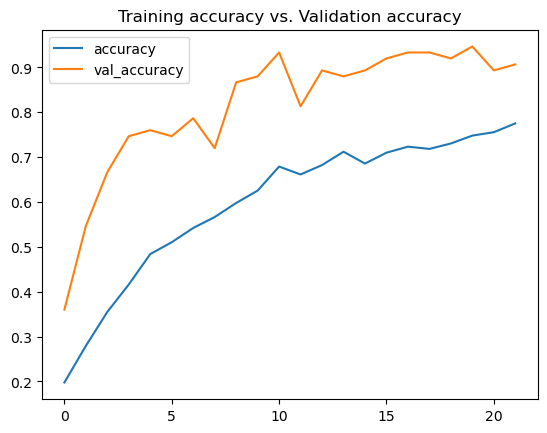

In [48]:
# Plot training accuracy vs. validation accuracy 
metrics = pd.DataFrame(cnn.history.history)
metrics.head()

metrics[['accuracy','val_accuracy']].plot()
plt.title('Training accuracy vs. Validation accuracy')
plt.show()

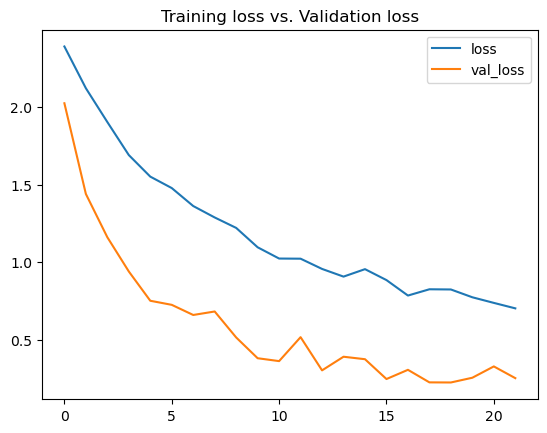

In [50]:
# Plot the model's training vs. validation loss
metrics[['loss','val_loss']].plot()
plt.title('Training loss vs. Validation loss')
plt.show()

**Best Epoch:** 22  
Although the accuracy continues to improve slightly in Epoch 19, the validation loss increases significantly (from 0.2232 to 0.3268). This increase in validation loss could be an early sign of overtraining, where the model starts to perform better on the training data but worse on the validation data. Therefore, Epoch 22 is likely the optimal point, balancing both high validation accuracy and low validation loss.

## Model Evaluation
It is expected that the validation and test performance is higher than the training performance, as test and validation images are hand-chosen to be the best. However, training performance may be the best metrics to evaluate the model performance on the actual unseen image in this case. 

In [60]:
y_pred = cnn.predict(test_dataset)

test_dataset.reset()
y_true = []
for i in range(len(test_dataset)):
    y_true.extend(np.argmax(test_dataset[i][1], axis=1))

y_true = np.array(y_true)

y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_true, y_pred_classes, 
                            target_names=test_dataset.class_indices.keys()))

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
                           precision    recall  f1-score   support

          AMERICAN AVOCET       1.00      0.80      0.89         5
        AMERICAN FLAMINGO       1.00      0.80      0.89         5
               BALD EAGLE       1.00      0.80      0.89         5
         BANDED BROADBILL       1.00      1.00      1.00         5
                 BARN OWL       1.00      0.80      0.89         5
BLONDE CRESTED WOODPECKER       1.00      1.00      1.00         5
                     CROW       0.71      1.00      0.83         5
                      IWI       0.83      1.00      0.91         5
             LILAC ROLLER       0.83      1.00      0.91         5
                  PEACOCK       1.00      0.80      0.89         5
                   PUFFIN       1.00      1.00      1.00         5
      ROSY FACED LOVEBIRD       1.00      1.00      1.00         5
          RUDY KINGFISHER       1.00      1.00      1.00         5
            TRUMPTER 

Conclusion
- The classification model performed very well, achieving an overall accuracy of 92% across 15 bird species, with lowest accuracy of 0.67 in Trumpter Swan. Except Trumpter Swan and Crow, all precision and recall of other species exceed 0.80.
- The macro and weighted averages for precision, recall, and F1-score are all close to 0.92-0.94, confirming the model's effectiveness across the different classes.
- Thanks to the test images having the best quality, the accuracy ratio is really high. However, a better way to evaluate the model is probably shuffle the test, validation and train images together and regroup the images. In this way, the evaluation metrics will be a better reflection of how the model is going to perform on an unseen image. 
- There are 80% male image and 20% female image, for the species with an evident sex dimorphism, the model may fail on predicting the females. 